# Calories Burnt Prediction

The goal is to predict how many calories were burned during a workout. 

The idea of this project is not only training a model to predict the task, but also filter data using sql commands. For that purpose, we will use duckdb in combination with pandas.

Dataset is from the following Kaggle competition: https://www.kaggle.com/competitions/playground-series-s5e5

## Importing Libraries

In [1]:
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import optuna as op
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np

c:\Users\Usuario\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA of the dataset

Even though we are using a Kaggle competition dataset, the objective of this project is not to submit predictions to the competition. Therefore, we are just gonna stick to the train dataset, which contains the values of the target.

We start then reading the data.

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [5]:
df = df.drop(columns=['id'])

Let's check if there are any null values.

In [11]:
df.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Now let's see some basic stats of the data.

In [6]:
df.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [8]:
df['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

It seems we have a pretty balance data in terms of the sex of the participants.

Now, in order to continue analyzing, let's convert the sex to numerical values.

In [13]:
num_df = df.copy()
num_df['Sex'] = num_df['Sex'].map({'male': 0 , 'female': 1})

Let's see if there's correlation between the variables, and see if some features are more correlated to the target.

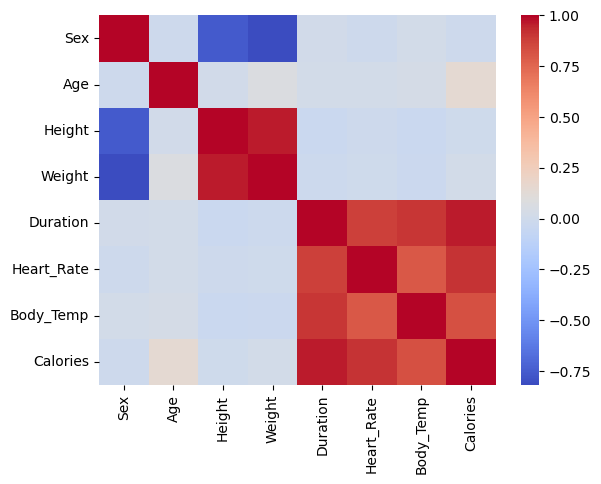

In [14]:
sns.heatmap(num_df.corr(), cmap='coolwarm')
plt.show()

As we can see, the duration of the workout, the heart rate and body temp during it seem to be more correlated to the calories expend, which make sense.

We can also see if women or men were expending more calories in this data.

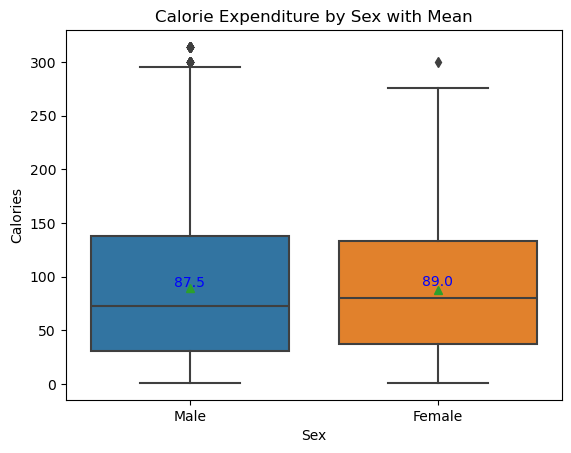

In [ ]:
ax = sns.boxplot(x='Sex', y='Calories', data=df, showmeans=True)

ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()])

mean_values = df.groupby('Sex')['Calories'].mean()

for i, sex in enumerate(mean_values.index):
    mean = mean_values[sex]
    ax.text(i, mean, f'{mean:.1f}', color='blue', ha='center', va='bottom')

plt.title('Calorie Expenditure by Sex with Mean')
plt.show()

So, we can see the mean and median are higher in females, but the highest values were reached in men.

## Filtering the data

Based on the correlation matrix, we will train our model using the features that showed the most correlation with the target. We also be focusing our attention on male individuals and considering the workouts whose calories expenditure and duration were between the first and third quartiles.

In [15]:
part_df = db.query("SELECT Duration, Heart_Rate, Body_Temp, Calories FROM num_df WHERE Sex == 0 AND Duration BETWEEN 8 AND 23 AND Calories BETWEEN 34 AND 136 ORDER BY Duration").to_df()

In [16]:
part_df

,Duration,Heart_Rate,Body_Temp,Calories
0,8.0,86.0,39.5,34.0
1,8.0,98.0,39.9,43.0
2,8.0,90.0,39.7,44.0
3,8.0,89.0,39.6,45.0
4,8.0,98.0,39.6,43.0
...,...,...,...,...
170415,23.0,102.0,41.0,127.0
170416,23.0,100.0,40.9,125.0
170417,23.0,102.0,40.6,116.0
170418,23.0,108.0,40.9,131.0


## Training the model

We will train a Lightgbm regression model, optimizing it with optuna and using cross validation in the process to avoid overfitting. We will evaluate the performance of the model with Root Mean Squared Logarithmic Error, since that is used on the competition.

In [17]:
X = part_df.copy()
y =X.pop('Calories')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 )

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "regression",  # Assuming a regression task
        "metric": "l2",  # Mean squared error for regression
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        'verbose': -1,
    }
    
    kf = KFold(n_splits=2, shuffle=True, random_state=1)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create LightGBM datasets
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train the model
        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate MSE for the current fold
        mse = np.sqrt(mean_squared_log_error(y_val, y_pred))
        mse_scores.append(mse)

    # Return the mean MSE over all folds
    return np.mean(mse_scores)

# Run Optuna
study = op.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Get best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-07-11 12:12:18,023] A new study created in memory with name: no-name-266bf5b5-70ef-48ba-b8c3-09e9db790b4d
[I 2025-07-11 12:12:19,232] Trial 0 finished with value: 0.14072875720120376 and parameters: {'learning_rate': 0.10528619521548163, 'num_leaves': 43, 'max_depth': 9, 'min_data_in_leaf': 12, 'lambda_l1': 0.76097037212631, 'lambda_l2': 2.732500874968092e-06, 'feature_fraction': 0.6725134741653053}. Best is trial 0 with value: 0.14072875720120376.
[I 2025-07-11 12:12:20,327] Trial 1 finished with value: 0.13940087673960433 and parameters: {'learning_rate': 0.026241774315093253, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 47, 'lambda_l1': 0.07624680631240613, 'lambda_l2': 6.880032082416674e-08, 'feature_fraction': 0.927100047120572}. Best is trial 1 with value: 0.13940087673960433.
[I 2025-07-11 12:12:21,042] Trial 2 finished with value: 0.16595392908899675 and parameters: {'learning_rate': 0.014888799293150574, 'num_leaves': 44, 'max_depth': 5, 'min_data_in_leaf': 4

Best parameters: {'learning_rate': 0.1316402736263924, 'num_leaves': 69, 'max_depth': 5, 'min_data_in_leaf': 44, 'lambda_l1': 1.1549031905893637e-08, 'lambda_l2': 0.008764449422249796, 'feature_fraction': 0.9643059943653489}


In [20]:
best_params

{'learning_rate': 0.1316402736263924,
 'num_leaves': 69,
 'max_depth': 5,
 'min_data_in_leaf': 44,
 'lambda_l1': 1.1549031905893637e-08,
 'lambda_l2': 0.008764449422249796,
 'feature_fraction': 0.9643059943653489}

In [21]:
best_params = {
    "objective": "regression",  # Assuming a regression task
    "metric": "l2",  # Mean squared error for regression
    "boosting_type": "gbdt",
    'learning_rate': 0.1316402736263924,
 'num_leaves': 69,
 'max_depth': 5,
 'min_data_in_leaf': 44,
 'lambda_l1': 1.1549031905893637e-08,
 'lambda_l2': 0.008764449422249796,
 'feature_fraction': 0.9643059943653489}

In [22]:
dtrain_full = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(best_params, dtrain_full, num_boost_round=100)

dtest = lgb.Dataset(X_test,label=y_test)
y_pred_test = final_model.predict(X_test)

In [23]:
np.sqrt(mean_squared_log_error(y_test, y_pred_test))

0.13432879948243098

Let's see which features were more important to the model in order to predict the target.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

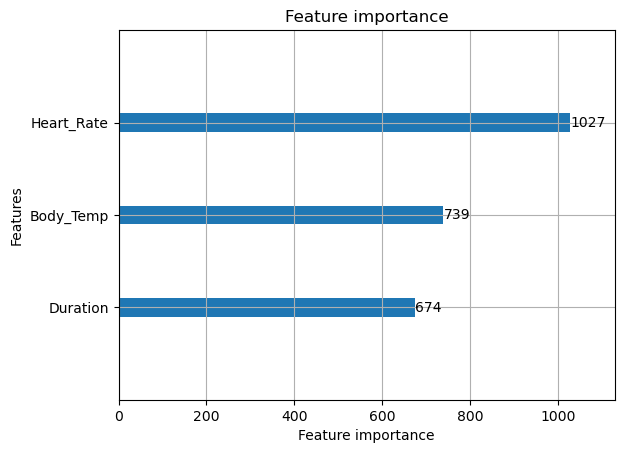

In [24]:
lgb.plot_importance(final_model, max_num_features=10)

Notice the difference on the correlation matrix, where the duration of the workout actually had more correlation with the calories expended.

That's it for this project, thank you for reading!
Fernán ZL